In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pavaann/pavan.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv("/kaggle/input/pavaann/pavan.csv")

In [3]:
X = df.drop([ 'FILENAME','Domain','TLD','URL', 'Title','label'], axis=1)  # Drop unnecessary columns
y = df['label']
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
from sklearn.preprocessing import MinMaxScaler

all_columns = df.columns.tolist()

numerical_features = [col for col in all_columns if col not in ['FILENAME', 'Domain', 'TLD', 'URL', 'Title', 'label']]

X = df[numerical_features]

scaler = MinMaxScaler()
scaler.fit(X)

X_normalized = scaler.transform(X)

df[numerical_features] = X_normalized

In [5]:


!pip install captum aix360 torchray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 28.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 27.1 MB/s eta 0:00:00
  Created wheel for torchray: filename=torchray-1.0.0.2-py3-none-any.whl size=444010 sha256=d4f8fd8dd9778f5e235410d64ba21da784d222d398f5449f318f930c5895c661
  Stored in directory: /root/.cache/pip/wheels/67/89/6f/9f783db1b9c9c2f31323a990f12e156e4f99d9ae15c9a2e96c
Successfully built torchray


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert Pandas DataFrames to NumPy arrays before creating tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)  # Reshape for output
X_test_tensor = torch.FloatTensor(X_test.values)

In [7]:
print(X_train_tensor.shape)

torch.Size([165056, 50])


In [8]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))
        return x

# Initialize the model
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

In [9]:

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:

num_epochs = 5
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

for epoch in range(num_epochs):
    model.train()
    for i in range(num_batches):
        # Get batch data
        start = i * batch_size
        end = start + batch_size
        X_batch = X_train_tensor[start:end]
        y_batch = y_train_tensor[start:end]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0027
Epoch [2/5], Loss: 0.0032
Epoch [3/5], Loss: 0.0017
Epoch [4/5], Loss: 0.0003
Epoch [5/5], Loss: 0.0003


In [11]:

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)
print(y_pred)

[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]


In [12]:
outputs = model(X_train_tensor)
print(outputs.shape)

torch.Size([165056, 1])


In [13]:

from captum.attr import IntegratedGradients
# Extract a single input sample from X_train_tensor
input_tensor = X_train_tensor[0].unsqueeze(0)  # Take the first sample and add batch dimension

target_label = torch.tensor(1)

# Initialize the Integrated Gradients
ig = IntegratedGradients(model)

# Compute attributions for the input samples with respect to the target class
attributions, delta = ig.attribute(input_tensor, return_convergence_delta=True)

# Print attributions and delta for interpretation of values
print('Attributions:', attributions)
print('Delta (convergence check):', delta)

Attributions: tensor([[-2.3979e-01, -6.0714e-02, -0.0000e+00,  4.8347e-01, -9.1759e-03,
         -5.1149e-05, -4.3088e-04, -2.5273e-02,  6.1144e-04, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -1.1494e-01, -5.4425e-03, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -2.4116e-02,
         -9.8584e-04,  2.7449e-02,  1.0195e+00, -1.0477e+00, -6.8808e-03,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -4.7684e-03,
         -0.0000e+00,  0.0000e+00,  2.3867e-02, -0.0000e+00,  0.0000e+00,
         -0.0000e+00,  2.7979e-02,  2.8822e-03,  2.3378e-03, -0.0000e+00,
         -0.0000e+00,  0.0000e+00, -0.0000e+00,  1.3733e-02,  6.8560e-02,
          9.3047e-02,  1.1894e-01,  5.0134e-01,  3.5066e-03,  5.6302e-02]],
       dtype=torch.float64)
Delta (convergence check): tensor([0.0146], dtype=torch.float64)


In [15]:
dominant_feature_index = 22  # Index of the dominant feature
dominant_feature_name = X_train.columns[dominant_feature_index]  # Get the column name

# Print the dominant feature name and its attribution value
print(f"The dominant feature is '{dominant_feature_name}' at index {dominant_feature_index} with an attribution value of {attributions_np[dominant_feature_index]}")


The dominant feature is 'LineOfCode' at index 22 with an attribution value of 1.0194564641234418


In [16]:
attributions.dim()

2

In [17]:
# Convert attributions to a numpy array and take the mean across the first axis
mean_attributions = attributions.detach().numpy().mean(axis=0)

# Ensure mean_attributions has the same length as X_train.columns
mean_attributions = mean_attributions[:len(X_train.columns)]

# Get indices of top 5 features
top_indices = mean_attributions.argsort()[-5:][::-1]

# Get top 5 feature names and their corresponding attributions
top_features = [(X_train.columns[i], mean_attributions[i], i) for i in top_indices]

# Print the results
for feature_name, attribution_value, index in top_features:
    print(f"Feature: {feature_name}, Attribution: {attribution_value:.4f}, Index: {index}")

Feature: LineOfCode, Attribution: 1.0195, Index: 22
Feature: NoOfSelfRef, Attribution: 0.5013, Index: 47
Feature: URLSimilarityIndex, Attribution: 0.4835, Index: 3
Feature: NoOfJS, Attribution: 0.1189, Index: 46
Feature: NoOfCSS, Attribution: 0.0930, Index: 45


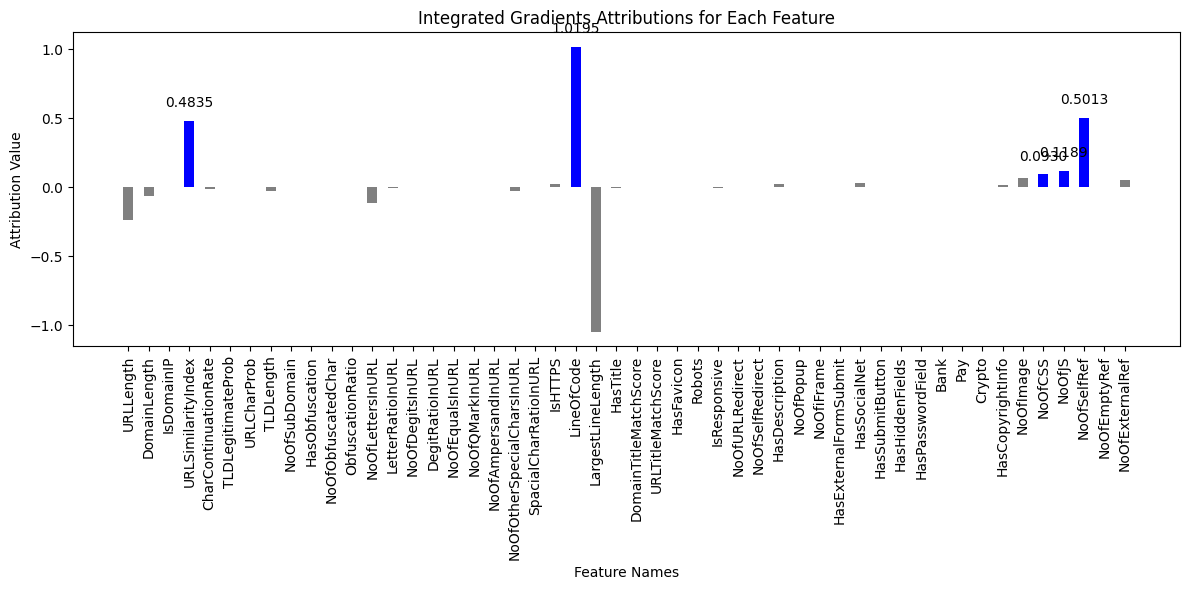

Feature: LineOfCode, Attribution: 1.0195, Index: 22
Feature: NoOfSelfRef, Attribution: 0.5013, Index: 47
Feature: URLSimilarityIndex, Attribution: 0.4835, Index: 3
Feature: NoOfJS, Attribution: 0.1189, Index: 46
Feature: NoOfCSS, Attribution: 0.0930, Index: 45


In [18]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Convert attributions to a numpy array and take the mean across the first axis 
# mean_attributions = attributions.detach().numpy().mean(axis=0)

# # Ensure mean_attributions has the same length as X_train.columns
# mean_attributions = mean_attributions[:len(X_train.columns)]

# # Get indices of top 5 features
# top_indices = mean_attributions.argsort()[-5:][::-1]

# # Get top 5 feature names and their corresponding attributions
# top_features = [(X_train.columns[i], mean_attributions[i], i) for i in top_indices]

# # Create a color array for the bar plot
# colors = ['blue' if i in top_indices else 'gray' for i in range(len(X_train.columns))]

# # Plotting
# plt.figure(figsize=(12, 6))
# x_pos = np.arange(len(X_train.columns))
# bars = plt.bar(x_pos, mean_attributions, width=0.5, color=colors)

# # Annotate the top 5 features with their values
# for index in top_indices:
#     plt.annotate(f"{mean_attributions[index]:.4f}", 
#                  (index, mean_attributions[index]), 
#                  textcoords="offset points", 
#                  xytext=(0, 10), 
#                  ha='center', 
#                  fontsize=10, 
#                  color='black')  # Adjust the color if needed

# # Customize the plot
# plt.xticks(x_pos, X_train.columns, rotation=90)
# plt.xlabel('Feature Names')
# plt.ylabel('Attribution Value')
# plt.title('Integrated Gradients Attributions for Each Feature')
# plt.tight_layout()
# plt.show()

# # Print the results for reference
# for feature_name, attribution_value, index in top_features:
#     print(f"Feature: {feature_name}, Attribution: {attribution_value:.4f}, Index: {index}")


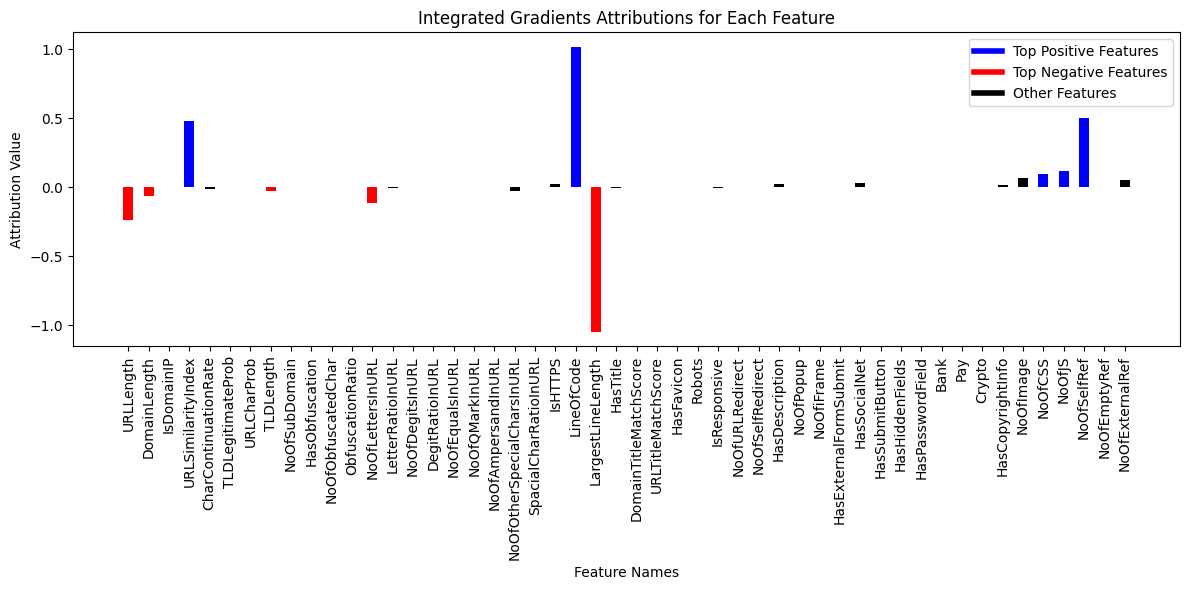

Top Positive Feature: LineOfCode, Attribution: 1.0195, Index: 22
Top Positive Feature: NoOfSelfRef, Attribution: 0.5013, Index: 47
Top Positive Feature: URLSimilarityIndex, Attribution: 0.4835, Index: 3
Top Positive Feature: NoOfJS, Attribution: 0.1189, Index: 46
Top Positive Feature: NoOfCSS, Attribution: 0.0930, Index: 45
Top Negative Feature: LargestLineLength, Attribution: -1.0477, Index: 23
Top Negative Feature: URLLength, Attribution: -0.2398, Index: 0
Top Negative Feature: NoOfLettersInURL, Attribution: -0.1149, Index: 12
Top Negative Feature: DomainLength, Attribution: -0.0607, Index: 1
Top Negative Feature: TLDLength, Attribution: -0.0253, Index: 7


In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Convert attributions to a numpy array and take the mean across the first axis 
mean_attributions = attributions.detach().numpy().mean(axis=0)

# Ensure mean_attributions has the same length as X_train.columns
mean_attributions = mean_attributions[:len(X_train.columns)]

# Get indices of top 5 positive features
top_positive_indices = mean_attributions.argsort()[-5:][::-1]

# Get indices of top 5 negative features (highest absolute values)
top_negative_indices = mean_attributions.argsort()[:5]

# Create a color array for the bar plot
colors = []
for i in range(len(X_train.columns)):
    if i in top_positive_indices:
        colors.append('blue')  # Top positive features in blue
    elif i in top_negative_indices:
        colors.append('red')   # Top negative features in red
    else:
        colors.append('black')  # Other features in black

# Plotting
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(X_train.columns))
plt.bar(x_pos, mean_attributions, width=0.5, color=colors)

# Customize the plot
plt.xticks(x_pos, X_train.columns, rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Attribution Value')
plt.title('Integrated Gradients Attributions for Each Feature')

# Create legend
blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='Top Positive Features')
red_patch = plt.Line2D([0], [0], color='red', lw=4, label='Top Negative Features')
black_patch = plt.Line2D([0], [0], color='black', lw=4, label='Other Features')
plt.legend(handles=[blue_patch, red_patch, black_patch], loc='upper right')

plt.tight_layout()
plt.show()

# Print the results for reference
top_positive_features = [(X_train.columns[i], mean_attributions[i], i) for i in top_positive_indices]
top_negative_features = [(X_train.columns[i], mean_attributions[i], i) for i in top_negative_indices]
for feature_name, attribution_value, index in top_positive_features:
    print(f"Top Positive Feature: {feature_name}, Attribution: {attribution_value:.4f}, Index: {index}")
for feature_name, attribution_value, index in top_negative_features:
    print(f"Top Negative Feature: {feature_name}, Attribution: {attribution_value:.4f}, Index: {index}")


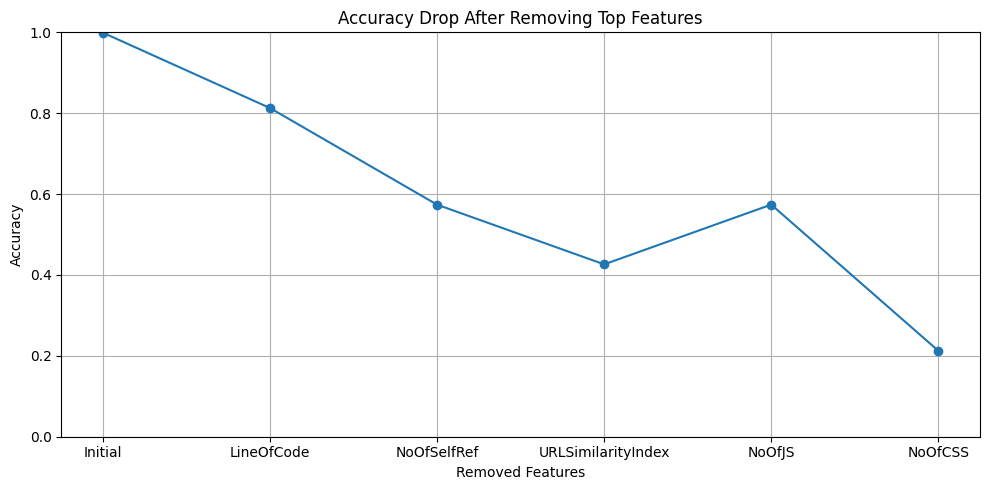

After removing 'Initial', accuracy: 0.9990
After removing 'LineOfCode', accuracy: 0.8127
After removing 'NoOfSelfRef', accuracy: 0.5738
After removing 'URLSimilarityIndex', accuracy: 0.4262
After removing 'NoOfJS', accuracy: 0.5739
After removing 'NoOfCSS', accuracy: 0.2127


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are defined
# Convert your labels to tensor
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)  # Reshape for output
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)  # Reshape for output

# Define the Neural Network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.output(x))
        return x

# Function to evaluate accuracy
def evaluate_model(model, X, y):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for evaluation
        predictions = model(X)  # Get raw predictions
        predicted_classes = torch.round(predictions)  # Assuming binary classification
    return accuracy_score(y.numpy(), predicted_classes.numpy())

# Step 1: Calculate initial accuracy
initial_model = NeuralNetwork(input_size)  # Initialize model with original input size
initial_model.load_state_dict(model.state_dict())  # Load the trained weights
initial_accuracy = evaluate_model(initial_model, X_test_tensor, y_test_tensor)

# Store accuracies
accuracies = [initial_accuracy]
feature_importances = []  # List to store features removed

# Assuming top_positive_features is defined based on previous attributions
for i in range(5):
    # Get the feature name and index of the ith top feature
    feature_name, _, index = top_positive_features[i]
    
    # Step 3: Remove the feature
    X_train_reduced = torch.cat((X_train_tensor[:, :index], X_train_tensor[:, index+1:]), dim=1)
    X_test_reduced = torch.cat((X_test_tensor[:, :index], X_test_tensor[:, index+1:]), dim=1)

    # Re-initialize the model with the new input size
    new_input_size = X_train_reduced.shape[1]
    model = NeuralNetwork(new_input_size)

    # Re-train the model
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_reduced[start:end]
            y_batch = y_train_tensor[start:end]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate new accuracy
    new_accuracy = evaluate_model(model, X_test_reduced, y_test_tensor)
    accuracies.append(new_accuracy)
    
    # Store the feature removed
    feature_importances.append(feature_name)

# Step 4: Visualization
plt.figure(figsize=(10, 5))
plt.plot(range(len(accuracies)), accuracies, marker='o')
plt.xticks(range(len(accuracies)), ['Initial'] + feature_importances)
plt.xlabel('Removed Features')
plt.ylabel('Accuracy')
plt.title('Accuracy Drop After Removing Top Features')
plt.ylim(0, 1)  # Adjust y-axis if accuracy is in [0, 1]
plt.grid()
plt.tight_layout()
plt.show()

# Print results
for feature, accuracy in zip(['Initial'] + feature_importances, accuracies):
    print(f"After removing '{feature}', accuracy: {accuracy:.4f}")


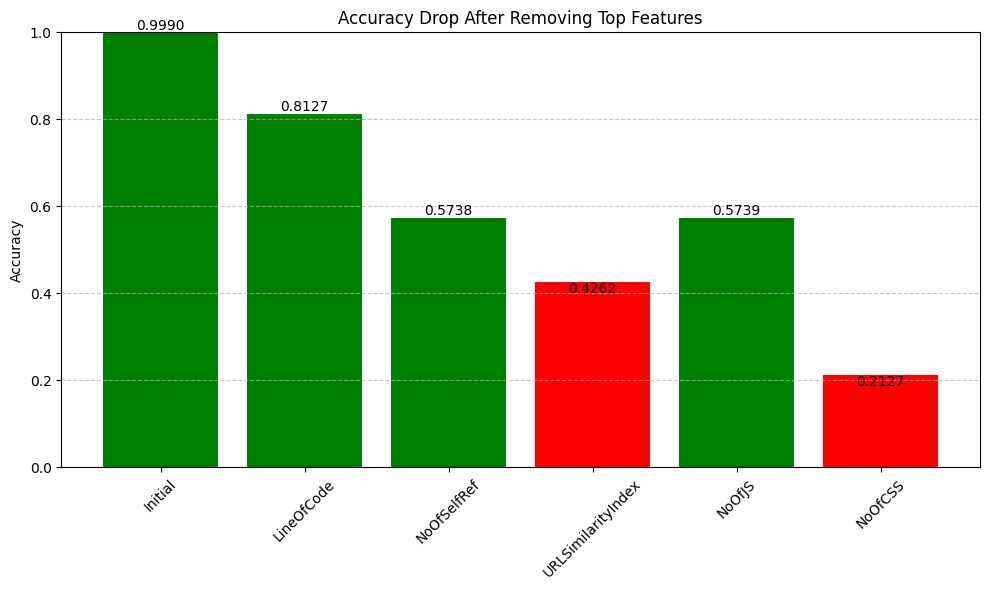

In [29]:
import matplotlib.pyplot as plt

# Prepare data for plotting
features = ['Initial'] + feature_importances
accuracies = accuracies

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(features, accuracies, color=['green' if acc >= 0.5 else 'red' for acc in accuracies])

# Add data labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom' if yval > 0.5 else 'top')

# Customize the plot
plt.ylim(0, 1)  # Set y-axis limits
plt.ylabel('Accuracy')
plt.title('Accuracy Drop After Removing Top Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


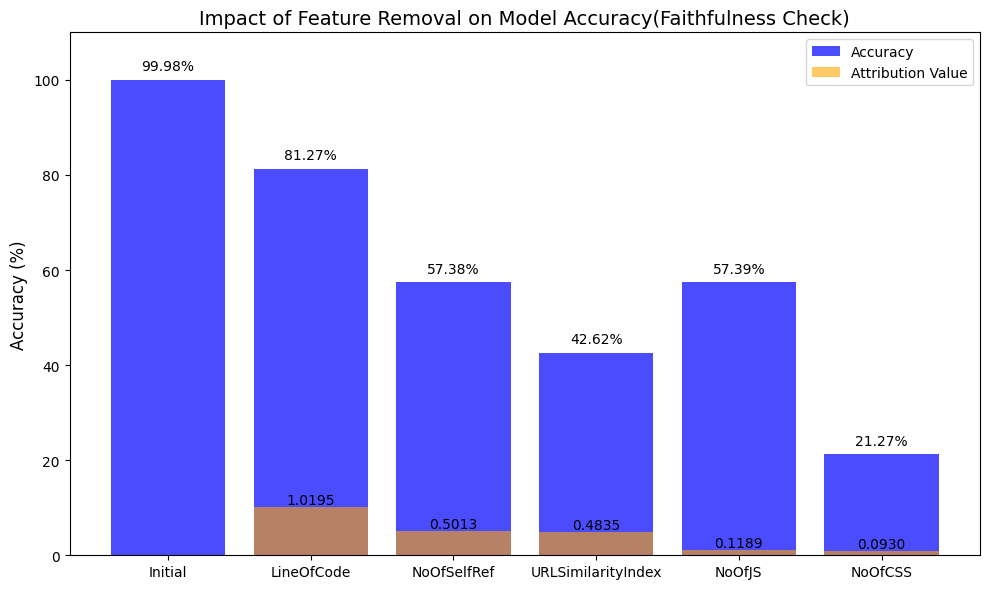

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for removed features and their accuracy values
removed_features = [
    'Initial', 
    'LineOfCode', 
    'NoOfSelfRef', 
    'URLSimilarityIndex', 
    'NoOfJS', 
    'NoOfCSS'
]
accuracies = [
    99.98,  # Accuracy before removal of 'Initial'
    81.27, 
    57.38, 
    42.62, 
    57.39, 
    21.27  # Accuracy after last feature removal
]

# Updated attribution values based on your input
attribution_values = [
    0.0,       # Attribution value for 'Initial'
    1.0195,    # LineOfCode
    0.5013,    # NoOfSelfRef
    0.4835,    # URLSimilarityIndex
    0.1189,    # NoOfJS
    0.0930     # NoOfCSS
]

# Create DataFrame for features
df_features = pd.DataFrame({
    'Features Removed': removed_features,
    'Attribution Value': attribution_values
})

# Set up for the combined plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for accuracy before and after each feature removal
accuracy_bars = ax1.bar(removed_features, accuracies, color='blue', alpha=0.7, label='Accuracy')
ax1.set_ylim(0, 110)
ax1.set_ylabel("Accuracy (%)", fontsize=12)

# Add accuracy values on top of bars
for index, value in enumerate(accuracies):
    ax1.text(index, value + 2, f"{value:.2f}%", ha='center', fontsize=10)

# Overlay attribution values vertically on the same plot as accuracy
for index, value in enumerate(attribution_values):
    # Scale attribution values for better visibility
    scaled_value = value * 10
    ax1.bar(index, scaled_value, color='orange', alpha=0.6, label='Attribution Value' if index == 1 else "")
    
    # Format the text to avoid displaying '0.000' for the 'Initial' feature
    text_value = f"{value:.4f}" if value != 0 else ""
    ax1.text(index, scaled_value + 0.01, text_value, ha='center', va='bottom', fontsize=10, color='black')

# Add title and legend
plt.title("Impact of Feature Removal on Model Accuracy(Faithfulness Check)", fontsize=14)

# Merging legends
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper right')

plt.tight_layout()  # Ensure the plot is compact
plt.show()
